En esta sección se llevará a cabo la construcción de los modelos supervisados de Machine Learning que calculen la probabilidad de que el paciente tenga su nivel de Colesterol HDL por debajo de los 40 mg/dL para posteriormente hacer la clasificación de Alterado (1) y No Alterado (0).

### Librerías utilizadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import roc_auc_score, roc_curve

#conda install python-graphviz
import graphviz

### Datos utilizados

Se importan los datos que resultaron del proceso de preparación de datos.

In [2]:
data = pd.read_csv('C:/Users/gusta/OneDrive/Documentos/Tesis/Datos/Datos_prep.csv') 

Se seleccionan las variables que serán utilizadas como variables dependientes.

In [3]:
var_predictivas = ['CC','VFA','CC_GRAS','CC_MUSC','CC_AGUA','PAM','TALLA','IMC']
X = data[var_predictivas] 
y = data['TARGET_HDL'] 

### Separación de datos

En el modelado predictivo, la estrategia estándar para una evaluación honesta del rendimiento de los modelos se da a través de la separación de los datos en dos subconjuntos. Una parte de la fuente de datos se utiliza para ajustar los modelos: el conjunto de datos de entrenamiento. El resto de la fuente de datos se utiliza para dar una estimación honesta final de la generalizacion de los modelos: el conjunto de datos de validación.

Para el presente trabajo el conjunto de entrenamiento representará el 70% de los datos originales y el conjunto de validación tendrá el 30% restante.

In [4]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 1449, 1: 308})


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=13719)
print('Train dataset shape %s' % Counter(y_train))
print('Test dataset shape %s' % Counter(y_test))

Train dataset shape Counter({0: 1019, 1: 210})
Test dataset shape Counter({0: 430, 1: 98})


Dado que la muestra de datos no esta balanceada (17.53% de Eventos vs 82.47% de No-Eventos) se utilizará una técnica que consiste en aplicar en simultáneo un algoritmo de subsampling y otro de oversampling al conjunto de datos. Se utilizará SMOTE (Synthetic Minority Oversampling Technique) para el oversampling: busca puntos vecinos cercanos y agrega puntos en linea recta entre ellos. Y se utilizará Tomek para el undersampling, el cual que quita elementos de la clase mayoritaria que sean "nearest neighbor" para delimitar mejor la zona limítrofe de las clases.

In [6]:
smotetomek = SMOTETomek(sampling_strategy=0.5,random_state=13719)
X_train, y_train = smotetomek.fit_resample(X_train, y_train)
print('Resampled train dataset shape %s' % Counter(y_train))

Resampled train dataset shape Counter({0: 992, 1: 482})


## Modelos supervisados para Clasificación

Acorde a lo presentado anteriormente, se utilizarán modelos basados en árboles.

### Árbol de decisión

El primer modelo que se contruye es un Árbol de Decisión, de la librería Scikit-learn, además, se hace uso del método "RandomizedSearchCV" para encontrar los parámetros óptimos para el modelo, usando el ROC AUC como métrica para la medición del performance de los modelos.

In [7]:
# Parámetros para el modelo:
param_dict_tr= dict(criterion=['gini','entropy'], splitter=['best','random'],
                    max_depth=range(2,30), max_features=range(2,9),
                    min_samples_leaf=[0.05], class_weight=['balanced'])

# Se crea el árbol de decisión para clasificación:
tr_clf = DecisionTreeClassifier()

# Autotuning del modelo:
rsgrid_tr = RandomizedSearchCV(tr_clf, param_dict_tr, cv=20, n_iter=40, n_jobs=-1,
                               scoring='roc_auc')
rsgrid_tr.fit(X_train,y_train)
tr_clf = rsgrid_tr.best_estimator_

# Se entrena el árbol de decisión:
tr_clf = tr_clf.fit(X_train,y_train)

A continuación, se muestran los parámetros del Árbol de Decisión con los cuales se maximizó el área debajo de la curva ROC. 

In [8]:
rsgrid_tr.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=22, max_features=8, min_samples_leaf=0.05)

### Random Forest

El segundo modelo que se contruye es un Random Forest, de la librería Scikit-learn, además, se hace uso del método "RandomizedSearchCV" para encontrar los parámetros óptimos para el modelo, usando el ROC AUC como métrica para la medición del performance de los modelos.

In [9]:
# Parámetros para el modelo:
param_dict_rf= dict(n_estimators=range(50,150), criterion=['gini','entropy'],
                    max_depth=range(20,30), max_features=range(2,9),
                    min_samples_leaf=[0.05], class_weight=['balanced'])

# Se crea el Random Forest para clasificación:
rf_clf = RandomForestClassifier()

#Autotuning del modelo:
rsgrid_rf = RandomizedSearchCV(rf_clf, param_dict_rf, cv=20, n_iter=40, n_jobs=-1,
                               scoring= 'roc_auc')
rsgrid_rf.fit(X_train,y_train)
rf_clf = rsgrid_rf.best_estimator_

# Se entrena el Random Forest:
rf_clf = rf_clf.fit(X_train,y_train)

A continuación, se muestran los parámetros del Random Forest con los cuales se maximizó el área debajo de la curva ROC.

In [10]:
rsgrid_rf.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=29, max_features=8, min_samples_leaf=0.05,
                       n_estimators=68)

### Gradient Boosting

El tercer modelo que se contruye es un Gradient Boosting, de la librería Scikit-learn, además, se hace uso del método "RandomizedSearchCV" para encontrar los parámetros óptimos para el modelo, usando el ROC AUC como métrica para la medición del performance de los modelos.

In [11]:
# Parámetros para el modelo:
param_dict_gb= dict(criterion=['friedman_mse', 'mse', 'mae'], 
                    loss=['deviance','exponential'], 
                    learning_rate=[0.05,0.10,0.15,0.20,0.25,0.30,0.5,0.8,1],
                    max_depth=range(20,30), max_features=range(2,9),
                    min_samples_leaf=[0.05], n_estimators=range(50,150))

# Se crea el Gradient Boosting para clasificación:
gb_clf = GradientBoostingClassifier()

#Autotuning del modelo:
rsgrid_gb = RandomizedSearchCV(gb_clf, param_dict_gb, cv=20, n_iter=40, n_jobs=-1,
                               scoring= 'roc_auc')
rsgrid_gb.fit(X_train,y_train)
gb_clf = rsgrid_gb.best_estimator_

# Se entrena el Gradient Boosting:
gb_clf = gb_clf.fit(X_train,y_train)

A continuación, se muestran los parámetros del Gradient Boosting con los cuales se maximizó el área debajo de la curva ROC.

In [12]:
rsgrid_gb.best_estimator_

GradientBoostingClassifier(criterion='mse', learning_rate=0.5, max_depth=25,
                           max_features=8, min_samples_leaf=0.05,
                           n_estimators=82)

### XGBoost

El último modelo que se contruye es un XGBoost, de la librería XGBoost, además, se hace uso del método "RandomizedSearchCV" para encontrar los parámetros óptimos para el modelo, usando el ROC AUC como métrica para la medición del performance de los modelos.

In [13]:
# Parámetros para el modelo:
param_dict_xgb= dict(booster=['gbtree', 'dart'],
                     eta=[0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                     max_depth=range(20,30),n_estimators= range(50,150),  
                     scale_pos_weight=[1,2,2.5])

# Se crea el XGBoost para clasificación:
xgb_clf = XGBClassifier()

#Autotuning del modelo:
rsgrid_xgb = RandomizedSearchCV(xgb_clf, param_dict_xgb, cv=20, n_iter=40, n_jobs=-1,
                                scoring= 'roc_auc')
rsgrid_xgb.fit(X_train,y_train)
xgb_clf = rsgrid_xgb.best_estimator_

# Se entrena el XGBoost:
xgb_clf = xgb_clf.fit(X_train,y_train)

A continuación, se muestran los parámetros del XGBoost con los cuales se maximizó el área debajo de la curva ROC.

In [14]:
rsgrid_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.25, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=24,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=134, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Estadísticos de precisión

Para medir el desempeño de los modelos se utilizará el conjunto de datos de validación y se analizarán, en primer lugar,  las curvas ROC, y del área debajo de las mismas, de cada uno de los modelos.

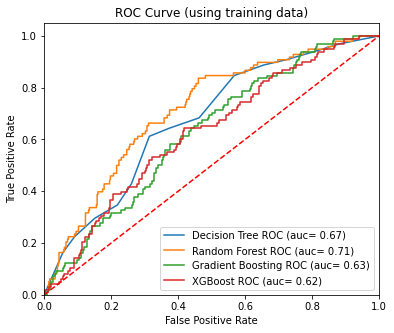

In [16]:
plt.figure(figsize=(6,5))
for m in modelos:
    modelo = m['modelo']
    fpr, tpr, thresholds = roc_curve(y_test, modelo.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_true=y_test, y_score=modelo.predict_proba(X_test)[:,1])
    plt.plot(fpr,tpr,label='%s ROC (auc= %0.2f)' % (m['label'], auc))
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05]) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using training data)')
plt.legend(loc="lower right")
plt.show()

En segundo lugar, se analizará la matriz de confusión de cada uno de los modelos junto con las métrícas de Precisión, Sensibilidad y el valor F2.

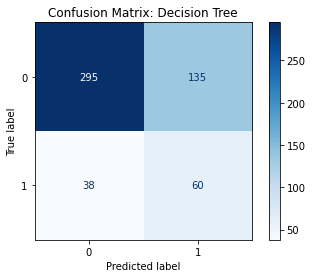

Precisión = 0.31
Sensibilidad = 0.61
F2 score = 0.68


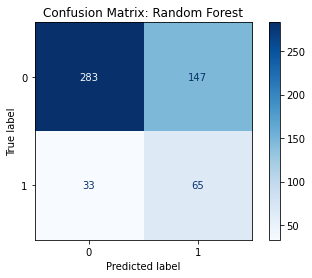

Precisión = 0.31
Sensibilidad = 0.66
F2 score = 0.67


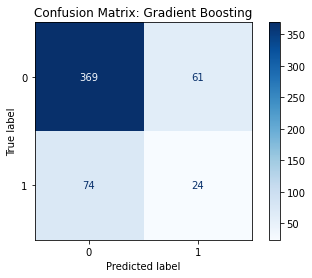

Precisión = 0.28
Sensibilidad = 0.24
F2 score = 0.74


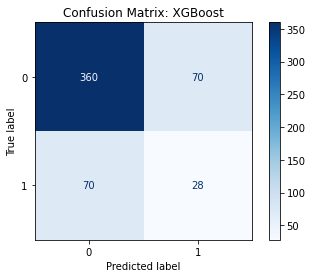

Precisión = 0.29
Sensibilidad = 0.29
F2 score = 0.73


In [15]:
modelos = [{'label':'Decision Tree','modelo':tr_clf},
           {'label':'Random Forest','modelo':rf_clf},
           {'label':'Gradient Boosting','modelo':gb_clf},
           {'label':'XGBoost','modelo':xgb_clf}]

for m in modelos:
    modelo = m['modelo']
    disp = plot_confusion_matrix(modelo, X_test, y_test,
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title('Confusion Matrix: %s' % (m['label']))
    plt.show()
    
    precision = precision_score(y_pred=modelo.predict(X_test),y_true=y_test)
    recall = recall_score(y_pred=modelo.predict(X_test),y_true=y_test)
    f2 = fbeta_score(y_pred=modelo.predict(X_test),y_true=y_test, beta=2, average='weighted')
    print('Precisión = %0.2f' % (precision))
    print('Sensibilidad = %0.2f' % (recall))
    print('F2 score = %0.2f' % (f2))    

Al explorar las curvas ROC y el AUC de los modelos se puede observar claramente que el modelo que tiene un mejor desempeño es el Random Forest y, al analizar las matrices de confusión, se confirma como modelo campeón porque es el modelo que identifica la mayor cantidad del verdaderos positivos y, por ende, minimiza los falsos negativos. 

Se busca minimizar la máximo la cantidad de falsos negativos ya que, al traducirlo a la práctica médica, lo que estaría haciendo el modelo es decirle al paciente que sus niveles de colesterol no están alterados, cuando si lo están, por lo que no recibiría ningún tipo de tratamiento para mitigar este padecimiento; por otro lado, los falsos negativos no afectan a los pacientes, ya que, en este caso, se le diría al paciente que tiene que hacer dieta y ejercicio para corregir estos valores, lo cual es algo benéfico para cualquier persona (con y sin Síndrome Metabólico), y se le haría (ahora si) una química sanguínea para que un médico determine los siguientes pasos.  

In [17]:
champion_model = rf_clf

### Umbral de probabilidad óptimo

Una vez seleccionado el modelo campeón, lo siguinte es identificar cuál el umbral (punto de corte) de probabilidad con el cual se mejora la clasificación hecha por el modelo. Para llevar a cabo esta tarea, se calculan las métricas de precisión usando diferentes puntos de corte. 

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, champion_model.predict_proba(X_test)[:,1])
predicted_proba = champion_model.predict_proba(X_test)[:,1]

In [19]:
precision_ls = []
recall_ls = []
fscore_ls = []
auc_ls = []

for thres in thresholds:
    y_pred = np.where(predicted_proba>thres,1,0)
    precision_ls.append(precision_score(y_true=y_test, y_pred=y_pred, zero_division=0))
    recall_ls.append(recall_score(y_true=y_test, y_pred=y_pred))
    fscore_ls.append(fbeta_score(y_pred=y_pred, y_true=y_test, beta=2, average='weighted'))
    auc_ls.append(roc_auc_score(y_true=y_test, y_score=y_pred))
    
thresholding = pd.concat([pd.Series(thresholds), pd.Series(precision_ls),
                         pd.Series(recall_ls),pd.Series(fscore_ls), pd.Series(auc_ls)],
                        axis=1)

thresholding.columns = ['thresholds', 'Precisión','Sensibilidad','Fscore','AUC']
thresholding.sort_values(by='AUC', ascending=False, inplace=True)
thresholding.head(n=10)

,thresholds,Precisión,Sensibilidad,Fscore,AUC
111,0.442818,0.290323,0.826531,0.591813,0.683033
112,0.436317,0.287719,0.836735,0.583285,0.682321
116,0.430056,0.285223,0.846939,0.574697,0.681609
113,0.435283,0.286713,0.836735,0.581284,0.681158
117,0.427909,0.284247,0.846939,0.572686,0.680446
110,0.443284,0.288809,0.816327,0.592339,0.679093
114,0.433126,0.284722,0.836735,0.577278,0.678832
115,0.432086,0.283737,0.836735,0.575272,0.677670
108,0.445445,0.289377,0.806122,0.596822,0.677480
109,0.445046,0.288321,0.806122,0.594840,0.676317


Recordemos que la intención es minimizar la cantidad de falsos negativos, en otras palabras, se busca maximizar la Sensibilidad del modelo. De acuerdo con la tabla anterior, el umbral 116 es el punto de corte que ayuda a tener una alta sensibilidad sin sacrificar demasiado la precisión y manteniendo al modelo con un buen desempeño (buen ROC AUC).

In [20]:
umbral = thresholds[116]

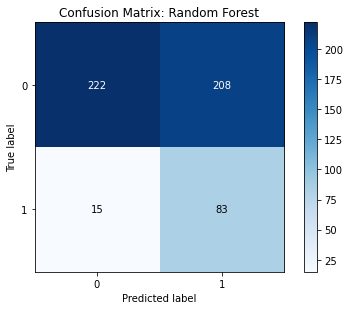

Precisión = 0.29
Sensibilidad = 0.85
F2 score = 0.57
ROC AUC = 0.68


In [22]:
y_pred_final = np.where(predicted_proba>umbral,1,0)

precision = precision_score(y_pred=y_pred_final, y_true=y_test)
recall = recall_score(y_pred=y_pred_final, y_true=y_test)
f2 = fbeta_score(y_pred=y_pred_final, y_true=y_test, beta=2, average='weighted')
auc = roc_auc_score(y_true=y_test, y_score=y_pred_final)
matriz = confusion_matrix(y_true=y_test, y_pred=y_pred_final)

true_label = ['0','1']
predicted_label = ['0','1']

fig, ax = plt.subplots()

im, cbar = heatmap(matriz, true_label, true_label, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: Random Forest')
plt.show()

print('Precisión = %0.2f' % (precision))
print('Sensibilidad = %0.2f' % (recall))
print('F2 score = %0.2f' % (f2))  
print('ROC AUC = %0.2f' % (auc))  

## Datos para ROI

Para hacer el ejercicio de ROI se utilizará un subconjunto de los datos originales (el 10%), los cuales serán calificados por cada uno de los modelos campeones, en este caso, el modelo campeón para detectar si el Colesterol HDL del paciente está alterado o no. La finalidad es, dentro de las conclusiones, determinar la relación costo-beneficio de usar este tipo de modelos para diagnosticar la prevalencia del Síndrome Metabólico en jóvenes mexicanos.

In [23]:
datos_roi = pd.read_csv('C:/Users/gusta/OneDrive/Documentos/Tesis/Datos/Datos_muestra.csv') 
X_roi = datos_roi[var_predictivas] 
y_roi = datos_roi['TARGET_HDL'] 

Se calculan las probabilidades y, haciendo uso del umbral óptimo, se hace la clasificación binaria:

In [24]:
predicted_proba = champion_model.predict_proba(X_roi)[:,1]
predicted_class = np.where(predicted_proba>umbral,1,0)

Se calcula la matriz de confusión junto con los estadísticos de precisión:

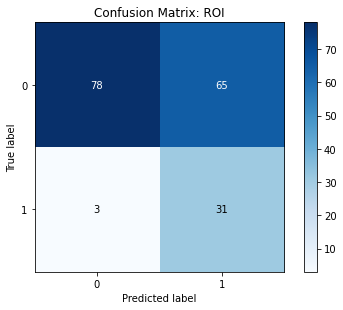

Precisión = 0.32
Sensibilidad = 0.91
F2 score = 0.61
ROC AUC = 0.73


In [25]:
precision = precision_score(y_pred=predicted_class, y_true=y_roi)
recall = recall_score(y_pred=predicted_class, y_true=y_roi)
f2 = fbeta_score(y_pred=predicted_class, y_true=y_roi, beta=2, average='weighted')
auc = roc_auc_score(y_true=y_roi, y_score=predicted_class)
matriz = confusion_matrix(y_true=y_roi, y_pred=predicted_class)

true_label = ['0','1']
predicted_label = ['0','1']

fig, ax = plt.subplots()

im, cbar = heatmap(matriz, true_label, true_label, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: ROI')
plt.show()

print('Precisión = %0.2f' % (precision))
print('Sensibilidad = %0.2f' % (recall))
print('F2 score = %0.2f' % (f2))  
print('ROC AUC = %0.2f' % (auc)) 

Se guarda la clasificación hecha por el modelo para que sirva de input al modelo de regresión:

In [26]:
datos_roi['HDL_Class'] = np.where(predicted_proba>umbral,1,0)

datos_roi.to_csv('C:/Users/gusta/OneDrive/Documentos/Tesis/Datos/Datos_roi.csv',
                 index=False)

## Interpretación del árbol de decisión

Por último, para ayudar a la interpretación del funcionamiento de los modelos, se muestra el árbol de decisión construido.

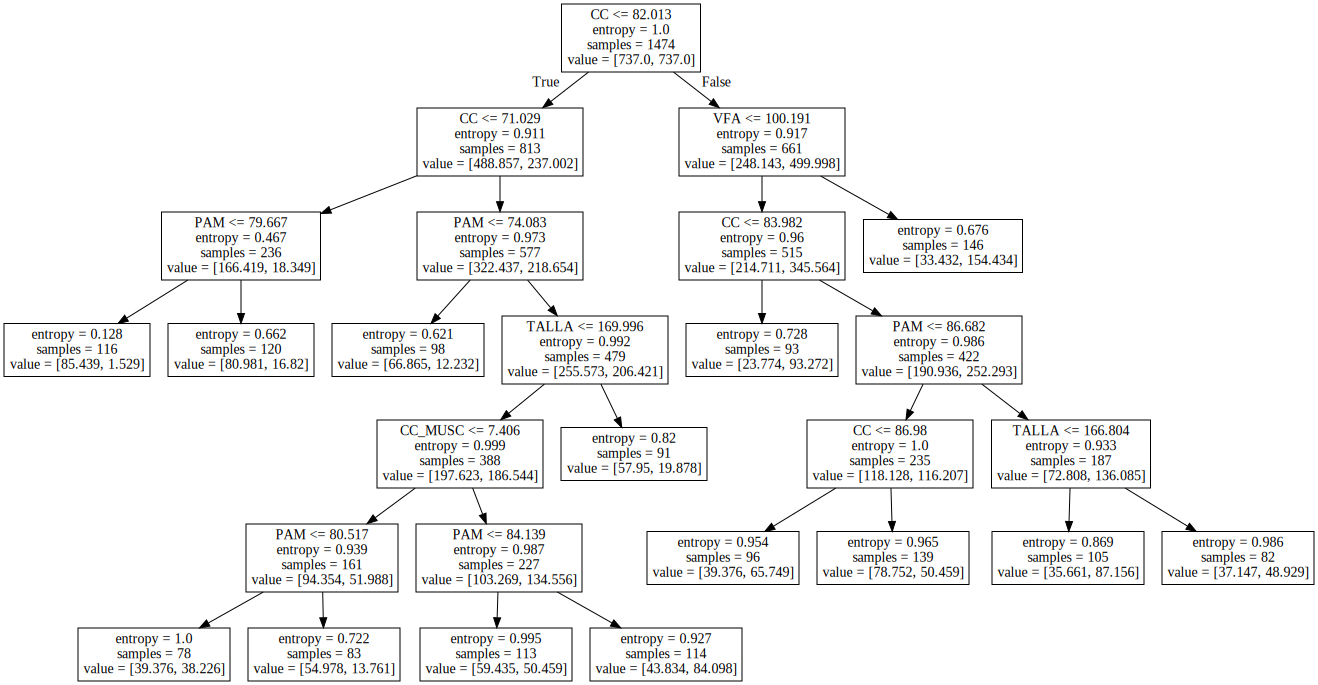

In [29]:
# Nombres:
Xnom=data[var_predictivas]

# Árbol:
tree.export_graphviz(tr_clf, out_file="tree_clf_HDL.dot", feature_names=Xnom.columns)
with open("tree_clf_HDL.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### Funciones para contruir la matriz de confusión

In [21]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts  